In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
 %%javascript
IPython.OutputArea.auto_scroll_threshold = 10

<IPython.core.display.Javascript object>

# Introduction

My task for this exercise was to analyze and provide a solution that would allow ads to be annotated with skills, responsibilities and other requirements for a successful candidate to perform in their role. From now on, I will call this information **target information**. 

My solution relies on the corpus provided containing 50000 job ads. Each ad has a `title`, an `abstract`, a `content` and some `metadata` information. In order to understand the data I analysed each field, presented in Section 1, and I have observed that the information that I need to extract is in the `content` field.

The ad’s `content` field contains HTML tags, therefore I manually checked if I could use the html structure to detect where in the article the target information is located. I observed that some articles contain information in the form of lists, like in the following example. 

![Example Ad](imgs/example_ad.png)

However, when I checked the html structure some lists were created with `UL` or `OL` tags while others were created using `BR` tags. Therefore, some articles contain structured information that I could use, but not all. 
    
With all this information in mind, I came up with two approaches to address the problem. A supervised one and another unsupervised. In the following lines, I will describe both of them, stating which one I chose.


## Supervised approach

The supervised approach that I came up with has the following steps:
    
1. Identify the sentences that contain the target information using a classification model.
2. Parse each sentence to detect the dependency relations between the words in the sentence.
3. Use manually created rules to identify the target information in the sentence. 

To explain this approach I will use the example already given.

Using a classification model we identify that the sentences in the last list: 

> * You will have experience within Early Education and a passion for business development.
> * To demonstrate ambition, focus, drive, enthusiasm, and professionalism.
> * Desire to become an expert in your area - we pride ourselves on our specialist knowledge.

show the required skills. We parse each sentence, i.e. every line, and using linguistic patterns we detect the chunks of text that are important for us. To show an example I will use the following sentence:
>You will have experience within Early Education and a passion for business development.

To show the dependency tree I used the Stanford parser for the sake of the visual representation. It looks like this:
![Dependency tree](imgs/dependency_tree.png)

Using the pattern:
> You will have -DOBJ-> */NN 

we can identify that the subtree whose root is the **dobj** of the verb **have** is a skill. In this case, we will obtain two skills, **experience with Early Education** and **passion for business development**.


### Evaluation
#### Requirements:
- a classifier that detects if a sentence contains the target information.
- a set of rules to identify important parts of the text. 

#### Pros:
- we can achieve linguistically correct information

#### Cons: 
- a lot of manual work to annotate a sufficient amount of sentences from the corpus, like which sentences contain the target information and which don’t. 
- even more work to write linguistic patterns to achieve sufficient coverage.


## Unsupervised approach

The unsupervised approach that I considered contains the following steps: 

1. Identify keywords in text.
2. Output of the extracted keywords, selecting those that represent the target information using similarities between vectorial representations of words. 

In order to explain this approach, I will use the same ad.
I expect that using algorithms of keywords extraction I will extract a list of keywords such as **building relationships**, **competitive salary**, **hard work**, **experience within early education**. Next, using vectorial representations of words, I want to detect that **experience within early education** and **building relationships** are skills/requirements for the role. 

In order to do that, I use vectorial representations of words to compute the general representation of the target relationships, $v_r$, and the vectorial representation for each keyword, $v_{kw}$. Finally, I order the keywords by the similarity between $v_{kw}$ and $v_r$.

### Evaluation
#### Requirements:
- a pre-trained model for the word vectorial representation.
- algorithms to extract keywords.

#### Pros:
- an easy implementation that does not require manual work.

#### Cons: 
- it might achieve worse results.

## Conclusions

In order to choose the right approach I took into consideration:

- **Resources**: working alone, for only one week, with a corpus containing 50000 ads.
- **Goal of the task**: evaluating my skills for an NLP position. 

Between the two approaches, I chose to use the unsupervised approach because it fits better with the available resources and I reckon it better fulfils the goal. 

# The algorithm

In [4]:
import json
import pprint
import pattern 
from nltk.corpus import stopwords
from gensim.utils import lemmatize
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import pickle
import pandas as pd
import html
from bs4 import BeautifulSoup, NavigableString
import re
import numpy as np
from keywords import KeywordsTfidf, KeywordsRake, KeywordsTextRank, GloveFilter
from utils import word_frequency, ngram_frequency, remove_html_tags, clean_text, cooccurrences_frequency, find_keywords_in_text, measure, load_data
from nltk.corpus import stopwords
from collections import defaultdict


In [5]:
INPUT_DATA="ads-50k.json"

## Data Loading

In [6]:
ads = load_data(INPUT_DATA)
print(f"Loaded {len(ads)} ads.")

Loaded 50000 ads.


## Corpus analysis

In order to understand the information that is usually written in the different fields of the ad, I look at the top words, bigrams, and, only for the content field, trigrams. I observe that the top words and bigrams in the ad's `title` and `abstract` are similar and represent job positions. However, in the `content` the top words belong to various semantic classes, therefore, in my opinion, the information about the skills, responsibilities, and requirements that I need to extract can be found in the ad `content`. 

Besides the three fields that contain just plain text, I also had a look over the information in the `metadata` field. 

### Titles analysis

In [7]:
titles = [ad['title'] for ad in ads]

In [8]:
title_word_freqs = word_frequency(titles)

In [9]:
pd.DataFrame(title_word_freqs[:50], columns=["Word", "Counts"])

,Word,Counts
0,manager,7988
1,senior,3825
2,officer,2672
3,assistant,2643
4,sales,2502
5,engineer,2161
6,business,1962
7,service,1826
8,consultant,1822
9,project,1718


In [10]:
title_bigram_freqs = ngram_frequency(titles, 2)

In [11]:
pd.DataFrame(title_bigram_freqs[:100], columns=["Bigrams", "Counts"])

,Bigrams,Counts
0,project manager,836
1,customer service,814
2,part time,732
3,full time,600
4,business development,554
...,...,...
95,marketing coordinator,90
96,head chef,90
97,office administrator,90
98,solution architect,88


### Abstracts analysis

In [12]:
abstracts = [ad['abstract'] for ad in ads]

In [13]:
abstract_word_freqs = word_frequency(abstracts)

In [14]:
pd.DataFrame(abstract_word_freqs, columns=["Word", "Counts"]).head(100)

,Word,Counts
0,team,11976
1,join,11211
2,opportunity,8585
3,experienced,7048
4,looking,6789
...,...,...
95,brand,935
96,day,923
97,level,919
98,culture,886


In [15]:
abstract_bigram_freqs = ngram_frequency(titles, 2)
pd.DataFrame(abstract_bigram_freqs, columns=["Bigrams", "Counts"]).head(100)

,Bigrams,Counts
0,project manager,836
1,customer service,814
2,part time,732
3,full time,600
4,business development,554
...,...,...
95,marketing coordinator,90
96,head chef,90
97,office administrator,90
98,solution architect,88


### Contents analysis

In [16]:
contents = [clean_text(remove_html_tags(ad['content'])) for ad in ads]

In [17]:
content_words_freq=word_frequency(contents)

In [18]:
pd.DataFrame(content_words_freq).head(100)

,0,1
0,experience,111481
1,work,95999
2,team,91611
3,role,90102
4,skills,71783
...,...,...
95,salary,13741
96,solutions,13725
97,systems,13725
98,australian,13675


In [19]:
content_bigram_freq = ngram_frequency(contents,2)

In [20]:
pd.DataFrame(content_bigram_freq).head(100)

,0,1
0,communication skills,14930
1,customer service,13802
2,full time,10068
3,skills experience,10021
4,ability work,9197
...,...,...
95,proven experience,2499
96,work closely,2499
97,business development,2492
98,please submit,2489


In [21]:
content_trigram_freqs = ngram_frequency(contents,3)

In [22]:
pd.DataFrame(content_trigram_freqs).head(100)

,0,1
0,please click apply,3922
1,click apply button,3221
2,excellent communication skills,3079
3,work life balance,3032
4,aboriginal torres strait,2863
...,...,...
95,responsibilities include limited,732
96,full time role,728
97,long term career,722
98,management skills ability,720


### Metadata

In the `metadata` object we find the following fields:

- `standout`: up to three key points about the ad
- `additionalSalaryText`: salary range
- `classification` and `subClassification`: categorization of the ad. In my opinion having this information may be useful to create a ontology of skill, responsabilities and requirements per caregory. 
- `location`, `area` and `suburb`: informtion about the location of the job advertised
- `workType`: 'Casual/Vacation', 'Contract/Temp', 'Full Time' or 'Part Time'

Not all the ads have data in all the fields, as you can see in the table below.

In [23]:
metadata_content = defaultdict(int)
for ad in ads:
    for key in ad['metadata'].keys():
        metadata_content[key] += 1
        
pd.DataFrame(metadata_content.items(), columns=['Name', 'Counts'])

,Name,Counts
0,standout,26685
1,additionalSalaryText,16349
2,classification,50000
3,subClassification,50000
4,location,50000
5,workType,50000
6,area,32844
7,suburb,37002


In [24]:
metadata = set()
classification = defaultdict(int)
sub_classification = defaultdict(int)
for ad in ads:
    classification[ad['metadata']['classification']['name']] += 1
    sub_classification[ad['metadata']['subClassification']['name']] += 1

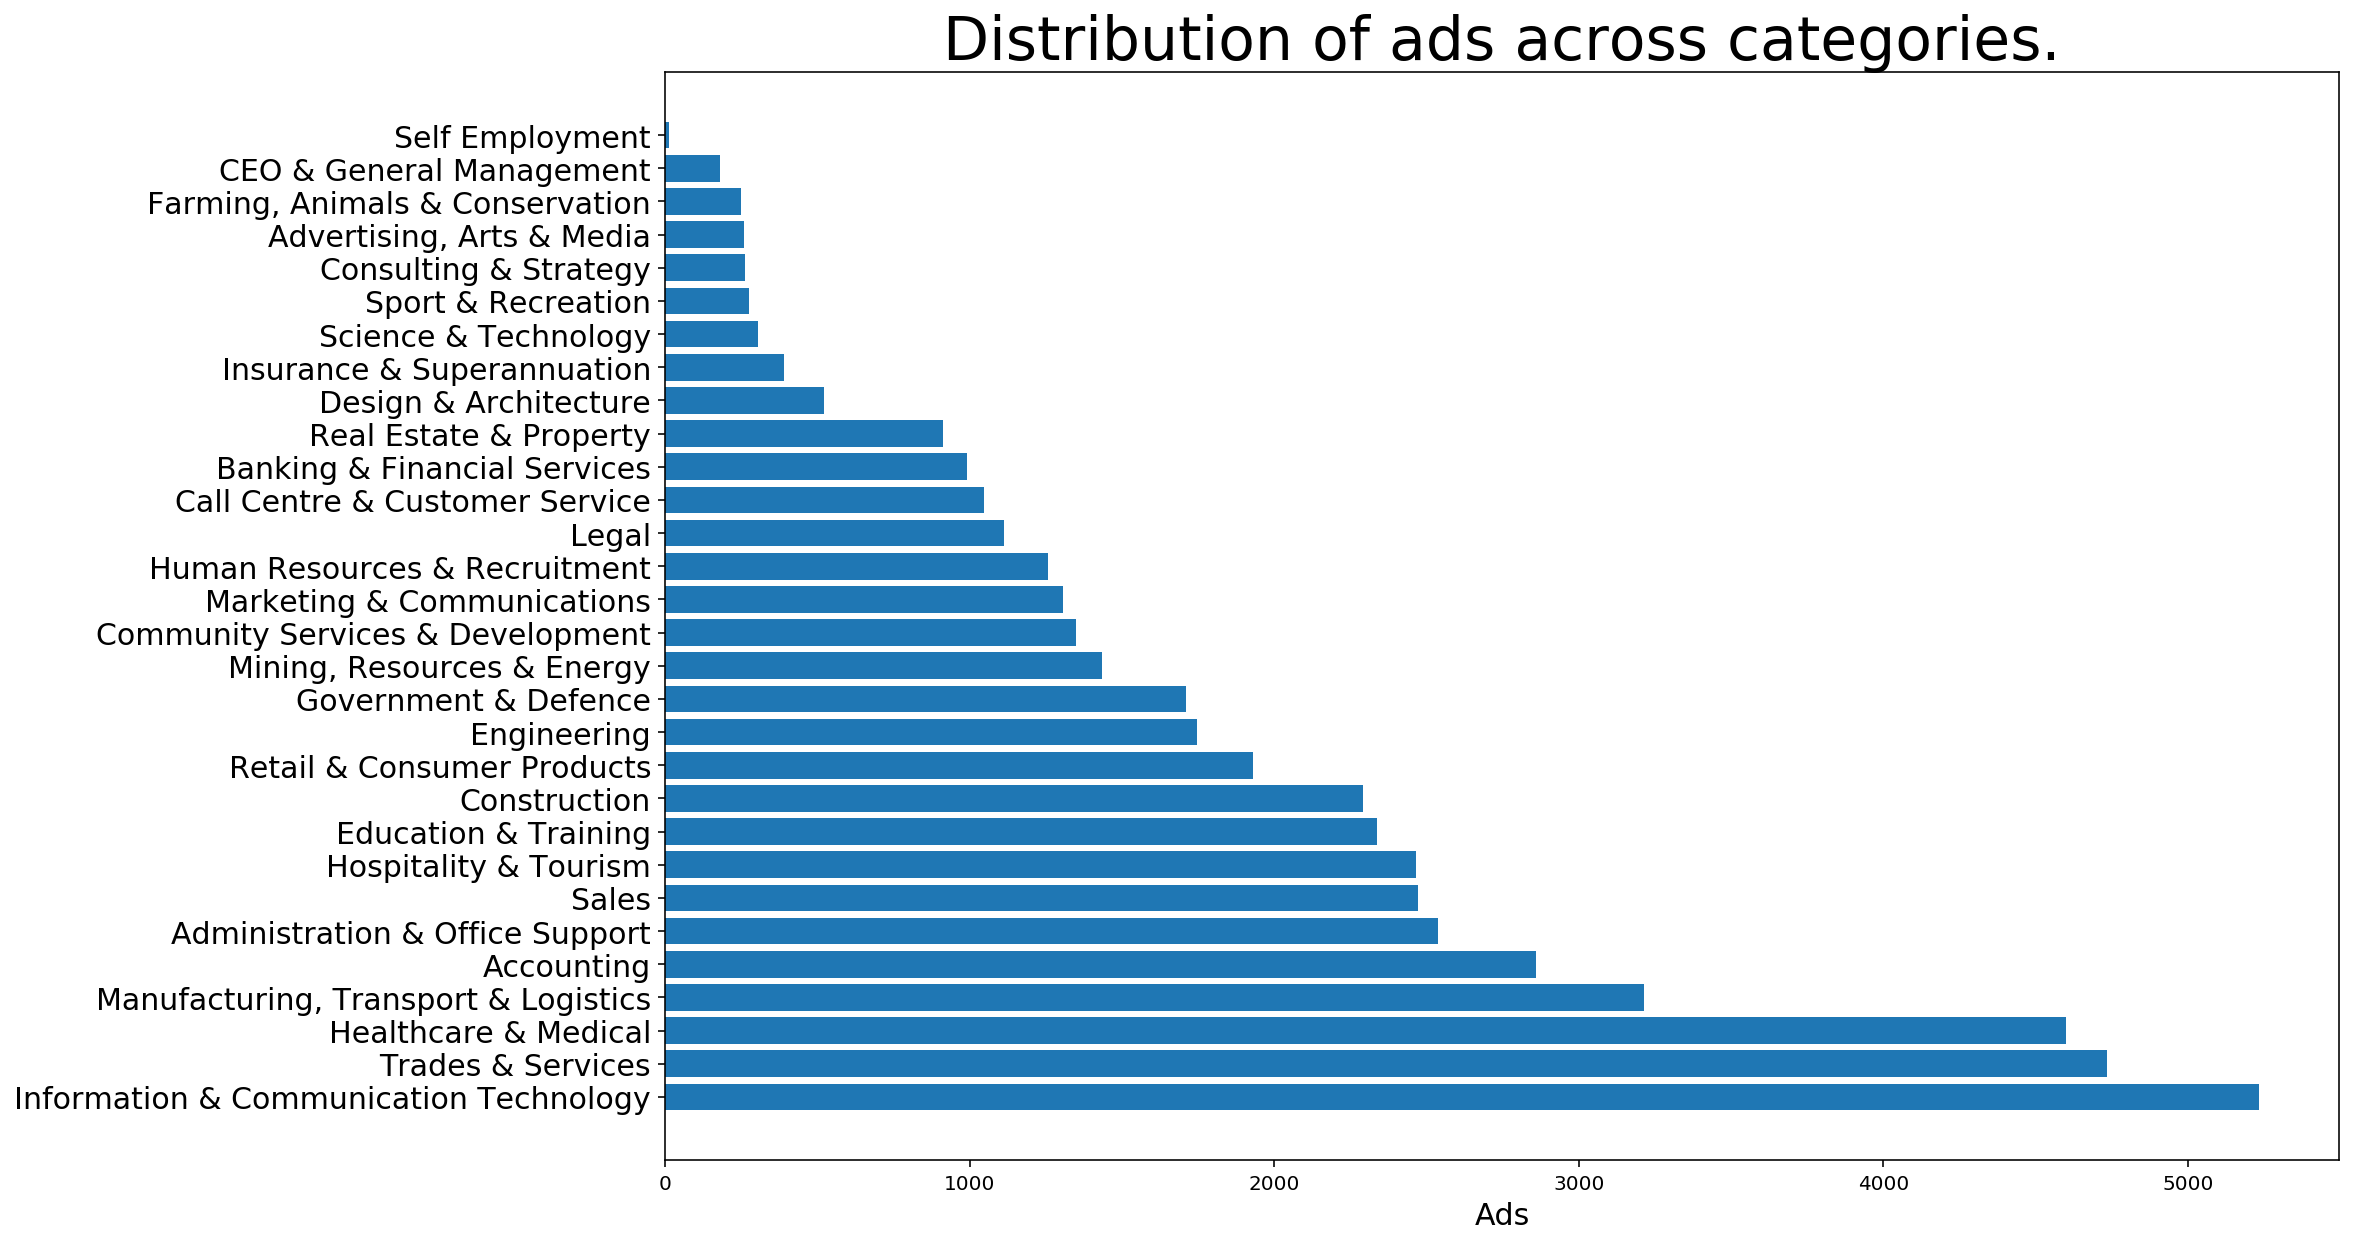

In [25]:
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import operator
def plot_bar_x(labels, counts, title):
    plt.figure(figsize=(15,10))
    index = np.arange(len(labels))
    plt.barh(index, counts)
    plt.xlabel('Ads', fontsize=15)
    plt.yticks(index, labels, fontsize=15)
    plt.title(title, fontsize=30)
    plt.show()

labels, counts = zip(*sorted(classification.items(), key=operator.itemgetter(1), reverse=True))
plot_bar_x(labels, counts, title='Distribution of ads across categories.')

NB: Because there are 337 subcategories in these ads, I cannot plot them so I will just print them as a table. 

In [26]:
pd.set_option('display.max_rows', 100)
pd.DataFrame(sub_classification.items(), columns=["Subcategory", "Counts"]).sort_values(by="Counts", ascending=False).head(100)

,Subcategory,Counts
0,Other,2688
4,Management,1618
32,Administrative Assistants,1131
29,Developers/Programmers,1072
9,Sales Representatives/Consultants,1038
13,"Warehousing, Storage & Distribution",907
63,Automotive Trades,901
8,Chefs/Cooks,802
1,Retail Assistants,726
71,Business/Systems Analysts,637



## Keyword extraction

As I explained before, for keywords extraction, I use the `content` field of the ad as input corpus, to obtain the target information. As part of the preprocessing, I remove the HTML tags and I clean some entities such as email addresses, URLs and numbers. Unfortunately, the text is still very noisy but due to time constraints, I didn't spend more time on this.

For keyword extraction, I chose to use three different types of algorithms:

- **Tf-Idf**: extracts keywords based on the frequency of a term in a document against its frequency in the whole corpus. 
- **Rake**: extracts keywords based on stopwords and word frequencies.
- **TextRank**: extracts keywords based on a graph representation of a text.

In [30]:
corpus = [clean_text(remove_html_tags(ad['content'])).lower() for ad in tqdm(ads)]

100%|██████████| 50000/50000 [01:18<00:00, 640.52it/s]


In [31]:
len(corpus)

50000

### Tf-Idf 

$Tf-Idf$ stands for Term Frequency - Inverse Document Frequency. It is a score that intends to reflect how important a term is for a document in a collection of documents. It's formula is:

$$tf-idf(t, d) = tf(t, d) * idf(t)$$

$tf(t, d)$ computes how many times the term $t$ occurs in the document $d$, and $idf(t)$ is the  inverse of the document frequency $df(d, t)$, how many documents contain the term $t$. To avoid dividing by zero, $idf(t)$ is computed using the formula: 

$$idf(d, t) = log [ (1 + n) / (1 + df(d, t)) ] + 1$$

To compute the $Tf-Idf$ score, first, we need to compute the $Idf$ for each term in the corpus. I serialize it as it takes a while to compute it and we use the same model for all the articles. This doesn't have to be recomputed for each new article, just updated periodically in order to have a reliable representation of the words in the corpus. 

For this exercise, I chose to use terms that are words, bigrams or trigrams, that occur at least 10 times in the corpus and I return the top keywords, 10% of the total number of tokens.

Note: I haven't had time to test these numbers, further analysis is required to set these parameters.


In [34]:
keywords_tfidf = KeywordsTfidf()
keywords_tfidf.compute_idf(corpus)

In [35]:
def get_tfidf_keywords(ad):
    ad_content = clean_text(remove_html_tags(ad['content'])).lower()
    keywords = keywords_tfidf.get_keywords(ad_content)
    keywords = find_keywords_in_text(keywords, ad['content'].split('\n'))
    return keywords

### RAKE 

RAKE stands for Rapid Automatic Keyword Extraction. For this approach, I used an existing [implementation in python](https://github.com/fabianvf/python-rake).

Rake uses a list of stop words in context to find keyword candidates. Each word is weighted based on its frequency and the frequency of the keyword candidates where it appears. Each candidate is finally weighted using the sum of the scores of its words. I return the top keywords, 10% of the total number of tokens.

Note: Using this approach all the candidate phrases do not contain stopwords. I haven't had time to test the number of keywords to be returned. 

In [36]:
keywords_rake = KeywordsRake()

In [37]:
def get_rake_keywords(ad):
    ad_content = clean_text(remove_html_tags(ad['content']))
    keywords = keywords_rake.get_keywords(ad_content)
    keywords, _ = zip(*keywords)
    return list(keywords)

### TextRank

TextRank is a graph-based algorithm for keyword extraction. The algorithm is inspired by the PageRank algorithm that was used to rank web pages at Google. In the case of webpages, we compute the page rank as follows.

$$PR(p_i) = ({1-d}) + d \sum_{p_j \in In(p_i)} \frac{PR (p_j)}{Out(p_j)}$$ 

where $p_1,p_2,...,p_N$ are the analysed webpages, $In(p_i)$ is the set of pages that link to $p_i$ and $Out(p_j)$ is the set of outbound links on page $p_j$ and $N$ is the total number of pages. $d$ is the residual probability, and $1-d$ represents the probability that the user will surf to a random page.

For the extraction of keywords, the algorithm computes a graph using candidate words that can belong to a keyword. The edges of the graph represent relations between words, in this case, they represent the co-occurrences of the words. Each edge is weighted by the logarithm of the number of co-occurrences of the corresponding words. Using this graph representation, the nodes are scored using the following formula:

$$WS(w_i) = ({1-d}) + d \sum_{w_j \in In(w_i)} \frac{w_{ij}}{\sum_{w_k \in Out(w_j)}w_{jk}}WS(w_j)$$

where $w_i$ are words, $In(w_i)$ and $Out(w_i)$ are co-occurring words with $w_i$. The graph that I used is undirected, therefore $In(w_i)=Out(w_i)$.

To extract keywords with TextRank I used a modified version of this [GitHub repository](https://github.com/davidadamojr/TextRank).

The original version creates a graph using the nouns and adjectives that occur in the text and it adds an edge between any 2 nodes, weighted by their edit distance. In my version, I connect only those 2 nodes that co-occur in corpus at least 10 times. Moreover, I changed the code so that the edge weighting scheme can be easily changed, as it does not belong to the algorithm. I marked my modifications in the `keywords/textrank/__init__.py` with `#silvia`.

There is another distribution of TextRank, called [pytextrank](https://github.com/DerwenAI/pytextrank), that I have tried. I liked it because it uses a direct graph created with dependency relations between words. However, it takes around 2 sec per ad to return the keywords, which in my opinion is too slow. Additionally, the parsing is encoded inside the framework, another thing that I disliked. 

To use the TextRank algorithm, I initially compute the co-occurrences between words in the corpus. In this case, we are interested to have as much information as possible for a reliable representation of co-occurring words, so I create a new corpus using the `title`, `abstract` and `content` of the articles.

In [38]:
corpus_cooc = []
for ad in tqdm(ads):
    corpus_cooc.append(clean_text(ad['title']).lower())
    corpus_cooc.append(clean_text(ad['abstract']).lower())
    corpus_cooc.append(clean_text(remove_html_tags(ad['content'])).lower())

100%|██████████| 50000/50000 [01:25<00:00, 588.10it/s]


In [39]:
KeywordsTextRank.compute_coocurrences(corpus_cooc)

100%|██████████| 1006780/1006780 [00:00<00:00, 1225261.19it/s]


In [41]:
keywords_textrank = KeywordsTextRank()

In [42]:
def get_textrank_keywords(ad):
    ad_content = clean_text(remove_html_tags(ad['content'])).lower()
    keywords = keywords_textrank.get_keywords(ad_content)
    keywords, _ = zip(*keywords)
    
    return list(keywords)

### Final candidate keywords
Append the top keywords in the final list of keywords.

In [43]:
candidates_tfidf = get_tfidf_keywords(ads[0])
print(candidates_tfidf)

['hard work', 'make difference to children', 'difference to children lives', 'recruiting permanent', 'early', 'early childhood', 'range of existing', 'pulse', 'child care', 'crew', 'managing recruitment', 'deliver monthly', 'competitive salary and commission', 'commission structure with uncapped', 'everyone is heard', 'expenses', 'expenses', 'hard work', 'plenty of fun', 'support through our established', 'career development pathway', 'pathway', 'pathway', 'pathway and training', 'one of the best companies', 'services one of the largest', 'healthcare staffing', 'experience within early', 'early', 'early education', 'growing business in an exciting', 'pulse', 'child care', 'crew', 'early', 'early childhood', 'child care', 'centres and out of school hours', 'early', 'early childhood', 'trained educators', 'roles our specialist', 'early', 'early education', 'mandy', 'mandy']


In [44]:
candidates_rake = get_rake_keywords(ads[0])
print(candidates_rake)

['attending client visits', 'understanding client requirements', 'managing recruitment processes', 'deliver monthly targets', 'quarterly lunch clubs', 'independent clinical services', 'child care centres', 'school hours care', 'call mandy sheen', 'early childhood professionals', 'hard work whilst', 'candidate development strategy', 'early education backgrounds', 'recruiting permanent staff', 'uncapped earning potential', 'fast-growing business', 'team building days', 'competitive hard work', 'early education', 'building relationships', 'competitive salary', 'supportive team', 'international development', 'business development', 'specialist team', 'thriving business', 'career fairs', 'external events', 'coordinating resources', 'properly worked', 'commission structure', 'key player', 'offer opinions', 'financial rewards', 'celebratory meals', 'posh restaurant', 'socially active', 'great balance']


In [48]:
candidates_textrank = get_textrank_keywords(ads[0])
print(candidates_textrank)

['team building', 'supportive team', 'business development', 'exciting opportunity please', 'work', 'career development', 'experience', 'role', 'candidate development', 'understanding client requirements', 'support', 'exciting industry', 'hours care', 'services', 'permanent staff', 'opportunities', 'great', 'competitive salary', 'building relationships', 'training', 'people', 'specialist knowledge', 'early education', 'part', 'clients', 'key', 'early childhood', 'experienced', 'benefits', 'range', 'financial', 'recruitment', 'day', 'focus', 'children', 'sydney', 'certificate', 'drive', 'candidates', 'passion']


In [60]:
candidates = set(candidates_tfidf + candidates_rake + candidates_textrank)
candidates

{'attending client visits',
 'benefits',
 'building relationships',
 'business development',
 'call mandy sheen',
 'candidate development',
 'candidate development strategy',
 'candidates',
 'career development',
 'career development pathway',
 'career fairs',
 'celebratory meals',
 'centres and out of school hours',
 'certificate',
 'child care',
 'child care centres',
 'children',
 'clients',
 'commission structure',
 'commission structure with uncapped',
 'competitive hard work',
 'competitive salary',
 'competitive salary and commission',
 'coordinating resources',
 'crew',
 'day',
 'deliver monthly',
 'deliver monthly targets',
 'difference to children lives',
 'drive',
 'early',
 'early childhood',
 'early childhood professionals',
 'early education',
 'early education backgrounds',
 'everyone is heard',
 'exciting industry',
 'exciting opportunity please',
 'expenses',
 'experience',
 'experience within early',
 'experienced',
 'external events',
 'fast-growing business',
 'fina

## Keywords filter

The algorithms that I used for keyword extraction retrieve important keywords from a document, but our objective is to detect skills, responsabilities and other requirements.  Therefore, to detect those keywords that represent the target information, I used  [GloVe](https://nlp.stanford.edu/projects/glove/) pre-trained model to acquire vectorial representations of words. For each keyword extracted I compute its vectorial representation as mean of the vectorial representations of its words. 

$$v(\text{experience within early educatio}) = mean([v(\text{experience}),v(\text{within}), v(\text{early}), v(\text{educatio})])$$


In the vectorial representation of words, we know that the relationship between words are encoded in the distance between their vectorial representation: 

$$v(\text{king}-\text{queen}) = v(\text{man}-\text{women})$$

So, I tried to enconde the relationship of `having a skill` using a predefined list of skills and substracting the representation of skill from it. From now on, I address only the acquisition of skills as proof of concept.

In [50]:
glove_file='PLEASE DOWNLOAD A GLOVE PRECOMPUTED MODEL FROM https://nlp.stanford.edu/projects/glove/ AND SET THIS VARIABLE WITH THE PATH; I used GloVe trained on Wikipedia and Gigaword, with 100 dimensions'

In [70]:
vocabulary, _ = zip(*content_words_freq)
GloveFilter.initialize(glove_file, vocabulary=vocabulary)

400000it [09:05, 733.80it/s]
400000it [09:10, 726.39it/s]


In [71]:
glove_filter = GloveFilter()

In [72]:
topn = 20

In [73]:
final_keywords = glove_filter.filter_keywords(candidates,30)
final_keywords

[('competitive hard work', 0.80146104),
 ('understanding client requirements', 0.7940818),
 ('business development', 0.78598785),
 ('experience', 0.78391236),
 ('work', 0.7808696),
 ('specialist knowledge', 0.7789121),
 ('hard work', 0.7686739),
 ('experience within early', 0.7573397),
 ('hard work whilst', 0.75523245),
 ('focus', 0.7528898),
 ('managing recruitment processes', 0.74680173),
 ('career development', 0.741264),
 ('early education backgrounds', 0.72813153),
 ('candidate development strategy', 0.7280679),
 ('career development pathway', 0.7250649),
 ('early education', 0.721976),
 ('great balance', 0.7183232),
 ('independent clinical services', 0.71545774),
 ('building relationships', 0.7049985),
 ('international development', 0.70432043),
 ('early childhood professionals', 0.685948),
 ('exciting industry', 0.6785192),
 ('candidate development', 0.65023285),
 ('school hours care', 0.6493118),
 ('training', 0.6394417),
 ('support', 0.6366798),
 ('financial rewards', 0.636349

## Evaluation

To evaluate this task I had annotated manually 5 random ads. I extracted all the keywords from the context that can represent skills, even if they were stated in the article as requirements.  I found it difficult to separate the skills out of the role requirements. 
For instance in the sentence 

> The Service Group Director will be required to demonstrate **strong leadership** and **business management experience** and will possess a rounded experience of operational leadership of complex service groups in a clinical setting, preferably within a medicine directorate or the emergency pathway.

**strong leadership** and **business management experience** are requirements but in my opinion are also skills. 

As measure for keyword extraction the common measures, precision, recall, f1 and accurracy, are too strict because they don’t reflect partial matches. For instance, if the system extracts **management experience**  instead of **business management experience**, these measures would consider  **management experience** as incorrect.

Therefore I suggest to use precision and recall inspired from the the ROUGE system, that is a metric used in text summarization and machine translation:

$$Prec = \frac{\text{number of overlapping ngrams}}{\text{number of ngrams in the extracted keywords}}$$

$$Rec = \frac{\text{number of overlapping ngrams}}{\text{number of ngrams in the ground truth}}$$

$$F1 = \frac{2*Prec*Rec}{Prec+Rec}$$

In [75]:
annotated_ads = [0, 1, 25445, 35120, 35345]

for idx in annotated_ads:
    annotated_ad = ads[idx]
    with open(f"annotations/{annotated_ad['id']}.txt", "r") as handle:
        ground_truth = [line.strip() for line in handle.readlines()]
    candidates_tfidf = get_tfidf_keywords(annotated_ad)
    candidates_rake = get_rake_keywords(annotated_ad)
    candidates_textrank = get_textrank_keywords(annotated_ad)
    candidates = set(candidates_tfidf + candidates_rake + candidates_textrank)
    
    final_keywords = glove_filter.filter_keywords(candidates,30)
    final_keywords, _ = zip(*final_keywords)
    prec, rec, f, intersection = measure(final_keywords, ground_truth)
    print(sorted(intersection, key= lambda x: len(x), reverse=True))
    print(prec, rec, f)

['understanding client requirements', 'candidate development strategy', 'managing recruitment processes', 'building relationships', 'recruitment processes', 'candidate development', 'managing recruitment', 'understanding client', 'business development', 'development strategy', 'client requirements', 'experience within', 'understanding', 'relationships', 'requirements', 'competitive', 'recruitment', 'development', 'experience', 'candidate', 'processes', 'business', 'strategy', 'managing', 'building', 'client', 'within', 'focus']
0.3218390804597701 0.35443037974683544 0.3373493975903615
['entertainment product knowledge', 'outstanding customer service', 'results driven person', 'entertainment product', 'communication skills', 'outstanding customer', 'product knowledge', 'customer focused', 'customer service', 'results driven', 'entertainment', 'driven person', 'communication', 'outstanding', 'experience', 'knowledge', 'customers', 'customer', 'focused', 'product', 'service', 'results', '

## Results and Further work

The results obtained are not very good, and it doesn't surprise me due to the few supervision that it is involved in this approach. Therefore there are many paths for improvement:

1. Use a better text preprocessing scheme, apply a NER system and maybe even dependency parser.
2. Investigate the best parameters for the keyword extraction systems.
3. Replace the filtering approach based on Glove with a supervised model that predicts if a candidate keyword is a skill, responsability or requirement, based on contextual information and on the HTML tags. 
4. Improve the evaluation scheme, the actual scheme is very optimistic as it scores also words, and does not weigth more a bigram or trigram than a word.


# Use cases

#### Task: Consider a use case where your solution might be used for assisting advertisers to post new better written, concise ads. 

My solution aims at extracting tags that represent skills, responsibilities and other requirements. With a system that reliably extracts this information, we can use it to summarize the ad. This way, a candidate could skim through the summary of skills, responsibilities and requirements, before reading the whole ad, and get an idea if he is interested on the position.

#### Task: Consider a use case where your solution might be applied to streaming data.

My solution aims at extracting tags that represent skills, responsibilities and other requirements. If we have a system that reliably extracts these tags we can use it for streaming data to process each ad in real-time. The tags that are acquired can be proposed to the advertiser. He/She could choose the tags that best fit his requirements. 

For streaming processing the latency is very important, it should be in order of seconds or milliseconds, because we should have a balance between the number of ads that are uploaded on the platform in a period of time and the number of ads that are processed in the same period of time, if not we can overload the system and the solution will not be anymore in real-time.

# Thank you